In [1]:
# Advantage Actor Critic (A2C) with vectorized environments and GAE
# gymnasium docs for vectorized environments: https://www.gymlibrary.dev/content/vectorising/

In [2]:
import gymnasium as gym
from gymnasium.utils.play import play
import matplotlib.pyplot as plt

import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from tqdm import tqdm
from typing import List, Tuple

In [3]:
class A2C(nn.Module):
    """
    (Synchronous) Advantage Actor-Critic agent class
    
    Args:
        n_features: The number of features of the input state.
        n_actions: The number of actions the agent can take.
        device: The device to run the computations on (running on a GPU might be quicker for larger Neural Nets,
                for this code CPU is totally fine).
        critic_lr: The learning rate for the critic network (should usually be larger than the actor_lr).
        actor_lr: The learning rate for the actor network.
        n_envs: The number of environments that run in parallel (on multiple CPUs) to collect experiences.
    """
    def __init__(self, n_features: int, n_actions: int, device: torch.device, 
                 critic_lr: float, actor_lr: float, n_envs: int) -> None:
        """Initializes the actor and critic networks and the respective optimizers."""
        super(A2C, self).__init__()
        self.device = device
        self.n_envs = n_envs
        
        critic_layers = [
            nn.Linear(n_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1), # estimate V(s)
        ]

        actor_layers = [
            nn.Linear(n_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, n_actions), # estimate action logits (will be fed into a softmax later)
        ]

        # define actor and critic networks
        self.critic = nn.Sequential(*critic_layers).to(self.device)
        self.actor = nn.Sequential(*actor_layers).to(self.device)

        # define optimizers for actor and critic
        self.critic_optim = optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.actor_optim = optim.Adam(self.actor.parameters(), lr=actor_lr)
    
    def forward(self, x: np.ndarray) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass of the networks.
        
        Args:
            x: A batched vector of states.
        
        Returns:
            state_values: A tensor with the state values, with shape [n_envs,].
            action_logits_vec: A tensor with the action logits, with shape [n_envs, n_actions].
        """
        x = torch.Tensor(x).to(self.device)
        state_values = self.critic(x) # shape of state_value_vec: [n_envs,]
        action_logits_vec = self.actor(x) # shape of action_logits_vec: [n_envs, n_actions]
        return (state_values, action_logits_vec)

    def select_action(self, x: np.ndarray) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Returns a tuple of the chosen actions and the log-probs of those actions.
        
        Args:
            x: A batched vector of states.
        
        Returns:
            actions: A tensor with the actions, with shape [n_steps_per_update, n_envs].
            action_log_probs: A tensor with the log-probs of the actions, with shape [n_steps_per_update, n_envs].
            state_values: A tensor with the state values, with shape [n_steps_per_update, n_envs].
        """
        state_values, action_logits = self.forward(x)
        action_pd = torch.distributions.Categorical(logits=action_logits) # implicitly uses softmax
        actions = action_pd.sample()
        action_log_probs = action_pd.log_prob(actions)
        return (actions, action_log_probs, state_values)

    
    def get_losses(self, rewards: torch.Tensor, action_log_probs: torch.Tensor, 
                   value_preds: torch.Tensor, masks: torch.Tensor,
                   gamma: float, lam: float, device: torch.device) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Computes the loss of a minibatch (transitions collected in one sampling phase) for actor and critic.
        
        Args:
            rewards: A tensor with the rewards for each time step in the episode, with shape [n_steps_per_update, n_envs].
            action_log_probs: A tensor with the log-probs of the actions taken at each time step in the episode, with shape [n_steps_per_update, n_envs].
            value_preds: A tensor with the state value predictions for each time step in the episode, with shape [n_steps_per_update, n_envs].
            masks: A tensor with the masks for each time step in the episode, with shape [n_steps_per_update, n_envs].
            gamma: The discount factor.
            lam: The GAE hyperparameter. (lam=1 corresponds to Monte-Carlo sampling with high variance and no bias, 
                                          and lam=0 corresponds to normal TD-Learning that has a low variance but is biased
                                          because the estimates are generated by a Neural Net).
            device: The device to run the computations on (e.g. CPU or GPU).
        
        Returns:
            critic_loss: The critic loss for the minibatch.
            actor_loss: The actor loss for the minibatch.
        """
        T = len(rewards)
        advantages = torch.zeros(T, self.n_envs, device=device)
        
        # compute the advantages using GAE (paper: https://arxiv.org/abs/1506.02438)
        gae = 0.0
        for t in reversed(range(T-1)):
            td_error = rewards[t] + gamma * masks[t] * value_preds[t+1] - value_preds[t]
            gae = td_error + gamma * lam * masks[t] * gae
            advantages[t] = gae

        # calculate the loss of the minibatch for actor and critic 
        critic_loss = advantages.pow(2).mean()
        actor_loss = - (advantages.detach() * action_log_probs).mean()
        return (critic_loss, actor_loss)
        
    def update_parameters(self, critic_loss: torch.Tensor, actor_loss: torch.Tensor) -> None:
        """
        Updates the parameters of the actor and critic networks.
        
        Args:
            critic_loss: The critic loss.
            actor_loss: The actor loss.
        """        
        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()
        
        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()

In [4]:
# environment hyperparams
n_envs = 5
n_updates = 2000
n_steps_per_update = 128
randomize_domain = False

# agent hyperparams
gamma = 0.999
lam = 0.95 # hyperparameter for GAE
actor_lr = 0.001
critic_lr = 0.01

# Note: the actor has a slower learning rate so that the value targets become
# more stationary and are theirfore easier to estimate for the critic

# environment setup
if randomize_domain:
    envs = gym.vector.AsyncVectorEnv([
        lambda: gym.make(
            'LunarLander-v2',
            gravity=np.clip(np.random.normal(loc=-10.0, scale=1.0), a_min=-11.99, a_max=-0.01),
            enable_wind=np.random.choice([True,False]),
            wind_power=np.clip(np.random.normal(loc=15.0, scale=1.0), a_min=0.01, a_max=19.99),
            turbulence_power=np.clip(np.random.normal(loc=1.5, scale=0.5), a_min=0.01, a_max=1.99),
            max_episode_steps=600
        ) for i in range(n_envs)
    ])
    
else:
    envs = gym.vector.make('LunarLander-v2', num_envs=n_envs, max_episode_steps=600)

    
obs_shape = envs.observation_space.shape[1]
action_shape = envs.action_space[0].n
print('obs_shape:', obs_shape)
print('action_shape:', action_shape)

# set the device
device = torch.device('cpu') # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'using device: {device}')

# init the agent
agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr, n_envs)
print('Setup {} for training in {} {} LunarLander-v2 environment[s]!'
      .format(agent.__class__.__name__, n_envs, 'randomly parameterized' if randomize_domain else 'predefined'))

obs_shape: 8
action_shape: 4
using device: cpu
Setup A2C for training in 5 predefined LunarLander-v2 environment[s]!


In [5]:
# create a wrapper environment to save episode returns and episode lenghts
envs_wrapper = gym.wrappers.RecordEpisodeStatistics(envs, deque_size=n_updates)

critic_losses = []
actor_losses = []
mean_advantages = []

# use tqdm to get a progress bar for training
for sample_phase in tqdm(range(n_updates)):
    
    # we don't have to reset the envs, they just continue playing
    # until the episode is over and then reset automatically
    
    # reset lists that collect experiences of an episode (sample phase)
    ep_value_preds = torch.zeros(n_steps_per_update, n_envs, device=device)
    ep_rewards = torch.zeros(n_steps_per_update, n_envs, device=device)
    ep_action_log_probs = torch.zeros(n_steps_per_update, n_envs, device=device)
    masks = torch.zeros(n_steps_per_update, n_envs, device=device)
    
    # at the start of training reset all envs to get an initial state
    if sample_phase == 0:
        states, info = envs_wrapper.reset(seed=42)

    # play n steps in our parallel environments to collect data
    for step in range(n_steps_per_update):
        
        # select an action A_{t} using S_{t} as input for the agent
        actions, action_log_probs, state_value_preds = agent.select_action(states)
        
        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        states, rewards, terminated, truncated, infos = envs_wrapper.step(actions.tolist())
        
        ep_value_preds[step] = torch.squeeze(state_value_preds)
        ep_rewards[step] = torch.tensor(rewards, device=device)
        ep_action_log_probs[step] = action_log_probs
        
        # add a mask (for the return calculation later);
        # for each env the mask is 1 if the episode is ongoing and 0 if it is done
        masks[step] = torch.tensor([not term and not trunc for term,trunc in zip(terminated, truncated)])
    
    # calculate the losses for actor and critic
    critic_loss, actor_loss = agent.get_losses(ep_rewards, ep_action_log_probs, ep_value_preds, 
                                               masks, gamma, lam, device) # lam for GAE calculation is not used yet 
    
    # update the actor and critic networks
    agent.update_parameters(critic_loss, actor_loss)
    
    # log the losses
    critic_losses.append(critic_loss.detach().cpu().numpy())
    actor_losses.append(actor_loss.detach().cpu().numpy())


100%|███████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:23<00:00,  7.59it/s]


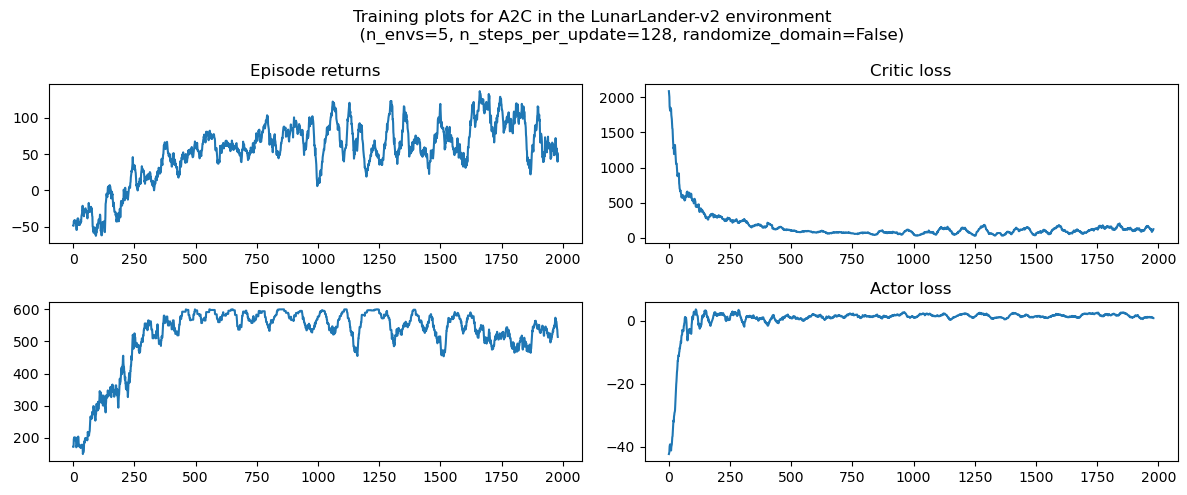

In [6]:
""" plot the results """

%matplotlib inline

rolling_length = 20
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
fig.suptitle(f'Training plots for {agent.__class__.__name__} in the LunarLander-v2 environment \n \
             (n_envs={n_envs}, n_steps_per_update={n_steps_per_update}, randomize_domain={randomize_domain})')

# episode return
axs[0][0].set_title('Episode returns')
episode_returns_moving_average = (
    np.convolve(
        np.array(envs_wrapper.return_queue).flatten(), np.ones(rolling_length), mode='valid'
    )
    / rolling_length
)
axs[0][0].plot(episode_returns_moving_average)

# episode length
axs[1][0].set_title('Episode lengths')
episode_length_moving_average = (
    np.convolve(np.array(envs_wrapper.length_queue), np.ones(rolling_length), mode='valid')
    / rolling_length)
axs[1][0].plot(episode_length_moving_average)

# critic loss
axs[0][1].set_title('Critic loss')
critic_losses_moving_average = (
    np.convolve(
        np.array(critic_losses).flatten(), np.ones(rolling_length), mode='valid'
    )
    / rolling_length
)
axs[0][1].plot(critic_losses_moving_average)

# actor loss
axs[1][1].set_title('Actor loss')
actor_losses_moving_average = (
    np.convolve(
        np.array(actor_losses).flatten(), np.ones(rolling_length), mode='valid'
    )
    / rolling_length
)
axs[1][1].plot(actor_losses_moving_average)

plt.tight_layout()
plt.show()

In [7]:
save_weights = True
load_weights = False

actor_weights_path = 'weights/actor_weights.h5'
critic_weights_path = 'weights/critic_weights.h5'
if not os.path.exists('weights'):
    os.mkdir('weights')

""" save network weights """
if save_weights:
    torch.save(agent.actor.state_dict(), actor_weights_path)
    torch.save(agent.critic.state_dict(), critic_weights_path)

    
""" load network weights """
if load_weights:
    agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr)
    
    agent.actor.load_state_dict(torch.load(actor_weights_path))
    agent.critic.load_state_dict(torch.load(critic_weights_path))
    agent.actor.eval()
    agent.critic.eval();

In [8]:
""" play a couple of showcase episodes """

n_showcase_episodes = 3

for episode in range(n_showcase_episodes): 
    print(f'starting episode {episode}...')
    
    # create a new sample environment to get new random parameters
    if randomize_domain:
        env = gym.make(
            'LunarLander-v2',
            render_mode='human',
            gravity=np.clip(np.random.normal(loc=-10.0, scale=2.0), a_min=-11.99, a_max=-0.01),
            enable_wind=np.random.choice([True,False]),
            wind_power=np.clip(np.random.normal(loc=15.0, scale=2.0), a_min=0.01, a_max=19.99),
            turbulence_power=np.clip(np.random.normal(loc=1.5, scale=1.0), a_min=0.01, a_max=1.99),
            max_episode_steps=500)
    else:
        env = gym.make(
            'LunarLander-v2',
            render_mode='human',
            max_episode_steps=500)
        
    # get an initial state
    state, info = env.reset()

    # play one episode
    done = False
    while not done:
        
        # select an action A_{t} using S_{t} as input for the agent
        with torch.no_grad():
            action, _, _ = agent.select_action(state[None, :])
        
        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        state, reward, terminated, truncated, info = env.step(action.item())

        # update if the environment is done
        done = terminated or truncated    

env.close()

starting episode 0...
starting episode 1...
starting episode 2...


In [9]:
""" try playing the environment yourself """

# play(gym.make('LunarLander-v2', render_mode='rgb_array'), keys_to_action={'w': 2, 'a': 1, 'd': 3}, noop=0)

' try playing the environment yourself '